In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf



In [2]:
start = '2014-01-01'
end = '2025-05-01'
stock = 'NVDA'

data = yf.download(stock, start, end)

/tmp/ipython-input-2-3593578100.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock, start, end)
[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2014-01-02,0.373906,0.376735,0.370605,0.375320,260092000
2014-01-03,0.369427,0.375320,0.368248,0.374613,259332000
2014-01-06,0.374377,0.377206,0.369662,0.373199,409492000
2014-01-07,0.380507,0.381921,0.375556,0.378149,333288000
2014-01-08,0.385693,0.387579,0.380507,0.381921,308192000


In [4]:
data.shape

(2849, 5)

In [5]:
data.tail()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2025-04-24,106.422607,106.532600,103.102838,103.472815,220815000
2025-04-25,111.002296,111.912229,105.722664,106.842582,251064700
2025-04-28,108.722450,110.362336,106.012632,109.682383,207708500
2025-04-29,109.012428,110.192347,107.432544,107.662524,170444300
2025-04-30,108.912437,108.912437,104.072777,104.462749,235044600


In [6]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2014-01-02,0.373906,0.376735,0.370605,0.375320,260092000
2014-01-03,0.369427,0.375320,0.368248,0.374613,259332000
2014-01-06,0.374377,0.377206,0.369662,0.373199,409492000
2014-01-07,0.380507,0.381921,0.375556,0.378149,333288000
2014-01-08,0.385693,0.387579,0.380507,0.381921,308192000


In [12]:
data.isnull().sum()

,,0
Price,Ticker,
Close,NVDA,0
High,NVDA,0
Low,NVDA,0
Open,NVDA,0
Volume,NVDA,0


In [15]:
df = pd.DataFrame(data)

# Save to CSV
df.to_csv('output.csv', index=True)

In [18]:
df1 = pd.read_csv('/content/output.csv')
df1.head()

,Date,Close,High,Low,Open,Volume
0,02-01-2014,0.373906,0.376735,0.370605,0.375320,260092000
1,03-01-2014,0.369427,0.375320,0.368248,0.374613,259332000
2,06-01-2014,0.374377,0.377206,0.369662,0.373199,409492000
3,07-01-2014,0.380507,0.381922,0.375556,0.378149,333288000
4,08-01-2014,0.385694,0.387580,0.380507,0.381922,308192000


In [19]:
ma_100_days = df1.Close.rolling(100).mean()

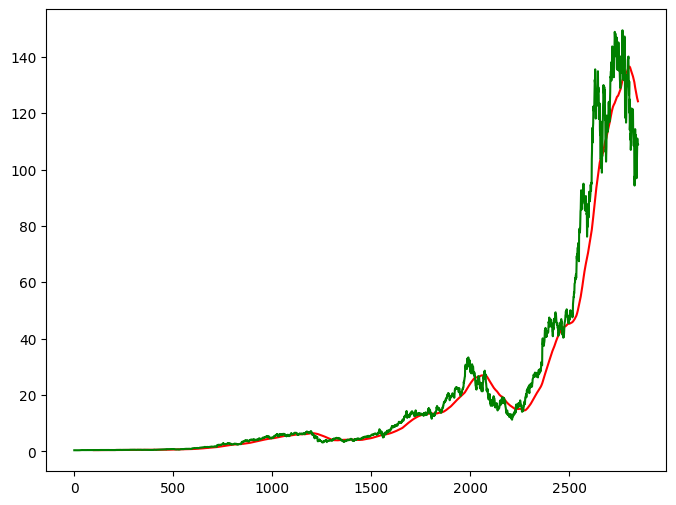

In [20]:
plt.figure(figsize = (8,6))
plt.plot(ma_100_days, 'r')
plt.plot(df1.Close, 'g')
plt.show()

The above graph is the MOVING AVERAGE of 100 Days, The average closing price of a stock over the past 100 trading days, recalculated daily.

In [21]:
ma_200_days = df1.Close.rolling(200).mean()

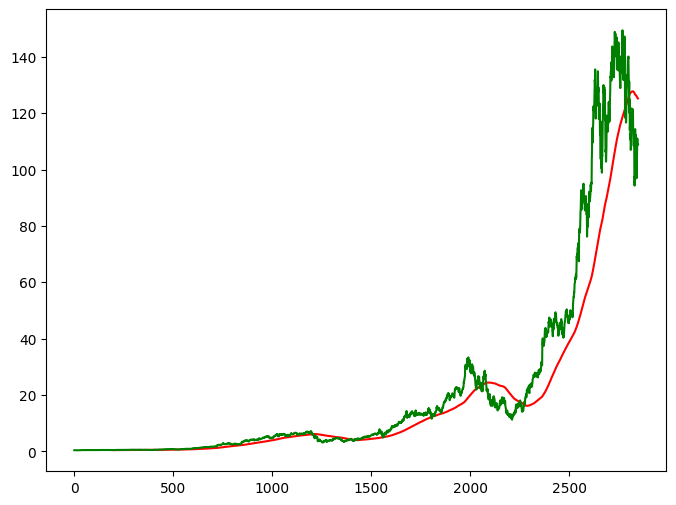

In [22]:
plt.figure(figsize = (8,6))
plt.plot(ma_200_days, 'r')
plt.plot(df1.Close, 'g')
plt.show()

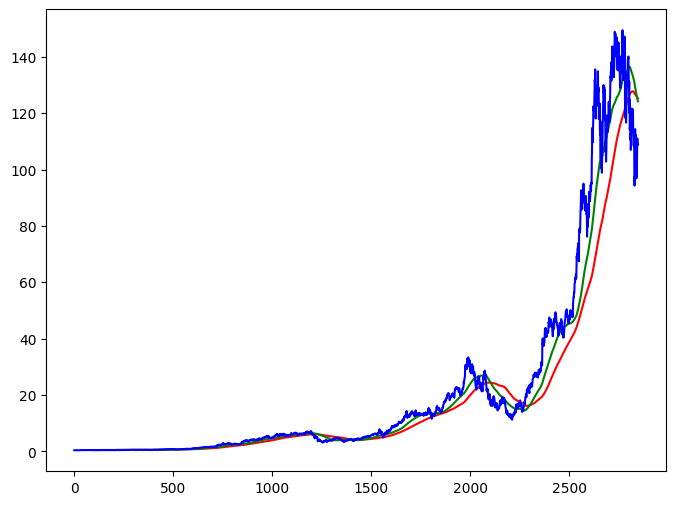

In [23]:
plt.figure(figsize = (8,6))
plt.plot(ma_200_days, 'r')
plt.plot(ma_100_days, 'g')
plt.plot(df1.Close, 'b')

plt.show()

In [24]:
df1.dropna(inplace=True)

In [25]:
df1.shape

(2849, 6)

In [26]:
df1_train = df1.Close[0 : int(len(df1)*0.80)]           # First 80%
df1_test  = df1.Close[int(len(df1)*0.80) : ]            # Remaining 20%

In [27]:
df1_train.shape

(2279,)

In [28]:
df1_test.shape

(570,)

# Scaling

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [30]:
df1_train_scaled = scaler.fit_transform(df1_train)

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [31]:
df1_train_scaled = scaler.fit_transform(pd.DataFrame(df1_train))


Eg.The LSTM NN model need to work in such a way that to predict a day's price, it must consider the prev 10 days' data. The cycle continues for the next day. In this particular case, we are taking 100 days' data to predict 101th day's stock price.

In [32]:
# ARRAY SLICE for LSTM

X = []
y = []

for i in range(100, df1_train_scaled.shape[0]):
    X.append(df1_train_scaled[i-100:i])
    y.append(df1_train_scaled[i,0])




In [34]:
# CONVERT X AND Y TO ARRAYS:

X = np.array(X)
y = np.array(y)

You’re doing manual feature engineering for a supervised learning task on time-series data:

Feature (X):
A sequence of 100 previous scaled closing prices

Shape: (100, 1) for each sample

Label (Y):
The next day's closing price

Shape: (1,) — a single value



You’re saying to the model:

“Here’s what the stock did over the past 100 days — now predict the next day’s price.”

This is how you convert a raw sequence into a supervised learning dataset, which models like LSTM, GRU, or even CNNs can learn from.

In [33]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

# MODEL

In [35]:
model = Sequential()
model.add(LSTM(units = 50, activation='relu', return_sequences=True,
          input_shape = ((X.shape[1],1))))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1)) #units = 1 means only one y value is needed

In [36]:
# compile

model.compile(optimizer='adam', loss = 'mean_squared_error')

In [37]:
# fitting

model.fit(X,y,epochs = 50, batch_size=32, verbose = 1 )

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - loss: 0.0370
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0046
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0038
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0040
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0032
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0032
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0037
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0035
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0032
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0026
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0026
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0030
Epoch 13/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0030
Epoch 14/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0027
Epoch 15/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0022
Ep

In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,285 (2.05 MB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 357,524 (1.36 MB)

# TESTING

In [39]:
past_100_days = df1_train.tail(100)


In [41]:
df1_test = pd.concat([past_100_days, df1_test], ignore_index=True)

In [42]:
df1_test

,Close
0,15.778240
1,15.445719
2,15.072259
3,13.916925
4,13.627343
...,...
665,106.422607
666,111.002296
667,108.722450
668,109.012428


In [44]:
df1_test_scale = scaler.fit_transform(pd.DataFrame(df1_test))

In [46]:
# ARRAY SLICE for LSTM (TEST)

X = []
y = []

for i in range(100, df1_test_scale.shape[0]):
    X.append(df1_test_scale[i-100:i])
    y.append(df1_test_scale[i,0])

In [47]:
# convert X and y to arrays

X,y = np.array(X), np.array(y)

In [48]:
y_predict = model.predict(X)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step


In [49]:
y_predict

array([[0.06890853],
       [0.06939168],
       [0.07004651],
       [0.07087262],
       [0.07186984],
       [0.07304037],
       [0.07435837],
       [0.07579249],
       [0.07733262],
       [0.07898413],
       [0.08074037],
       [0.08258606],
       [0.08451881],
       [0.08653524],
       [0.08862022],
       [0.09073257],
       [0.09285336],
       [0.09498006],
       [0.09709234],
       [0.09917669],
       [0.10120534],
       [0.10313267],
       [0.10491414],
       [0.10656421],
       [0.10811244],
       [0.10959516],
       [0.11103392],
       [0.11243089],
       [0.11378647],
       [0.11510504],
       [0.11638409],
       [0.11761348],
       [0.11879284],
       [0.11991282],
       [0.12095553],
       [0.12190325],
       [0.12275809],
       [0.1235319 ],
       [0.12425765],
       [0.12497112],
       [0.12570277],
       [0.12647584],
       [0.12730548],
       [0.12820081],
       [0.12916078],
       [0.13016331],
       [0.13118601],
       [0.132

In [52]:
# convert the MIN MAX 0 to 1 values to actual values:

scale = 1/scaler.scale_

In [53]:
y_predict = y_predict * scale

In [54]:
y = y * scale

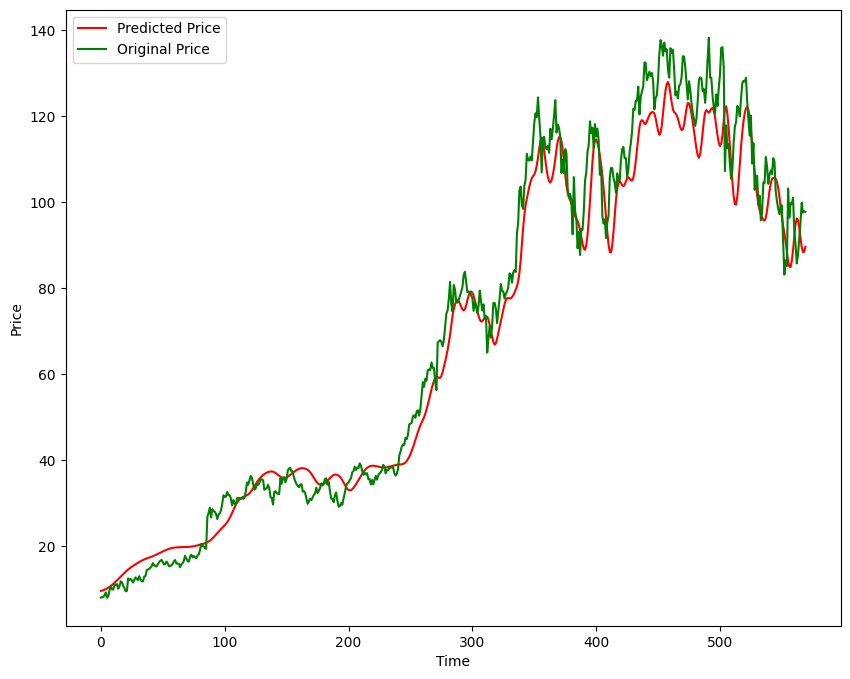

In [56]:
# Graph to compare y vs t_predict:

plt.figure(figsize=(10,8))
plt.plot(y_predict, 'r',label = 'Predicted Price')
plt.plot(y, 'g',label = 'Original Price')
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


In [57]:
model.save("stock_pred.keras")